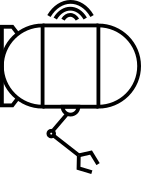

# Inspection planning with an Autonomous Underwater vehicle (AUV)

<div style="clear:both;"></div>

This Python notebook describes a planning problem concerning an unmanned autonomous inspection mission and demonstrates how to describe this planning problem in the [Unified Planning Framework](https://www.ai4europe.eu/research/ai-catalog/unified-planning-framework) and to find plans using the [Paraspace](https://github.com/SINTEF/paraspace) timelines planner.

## Problem description

We are in charge of planning the daily route of an autonomous underwater vehicle (AUV) doing inspections and maintenance on underwater equipment. The equipment is located along the coastline of a bay, with a base located offshore. 3D coordinates are given for the relevant locations. At different times of the day, the ocean current changes direction and influences the time it takes to travel between the locations. The AUV can flow along with the tides when going in or out for an easy ride or struggle against the tide if planned poorly. Furthermore, we have time windows dictating when inspection/maintenance can be performed. An example route for our AUV can be illustrated thusly:

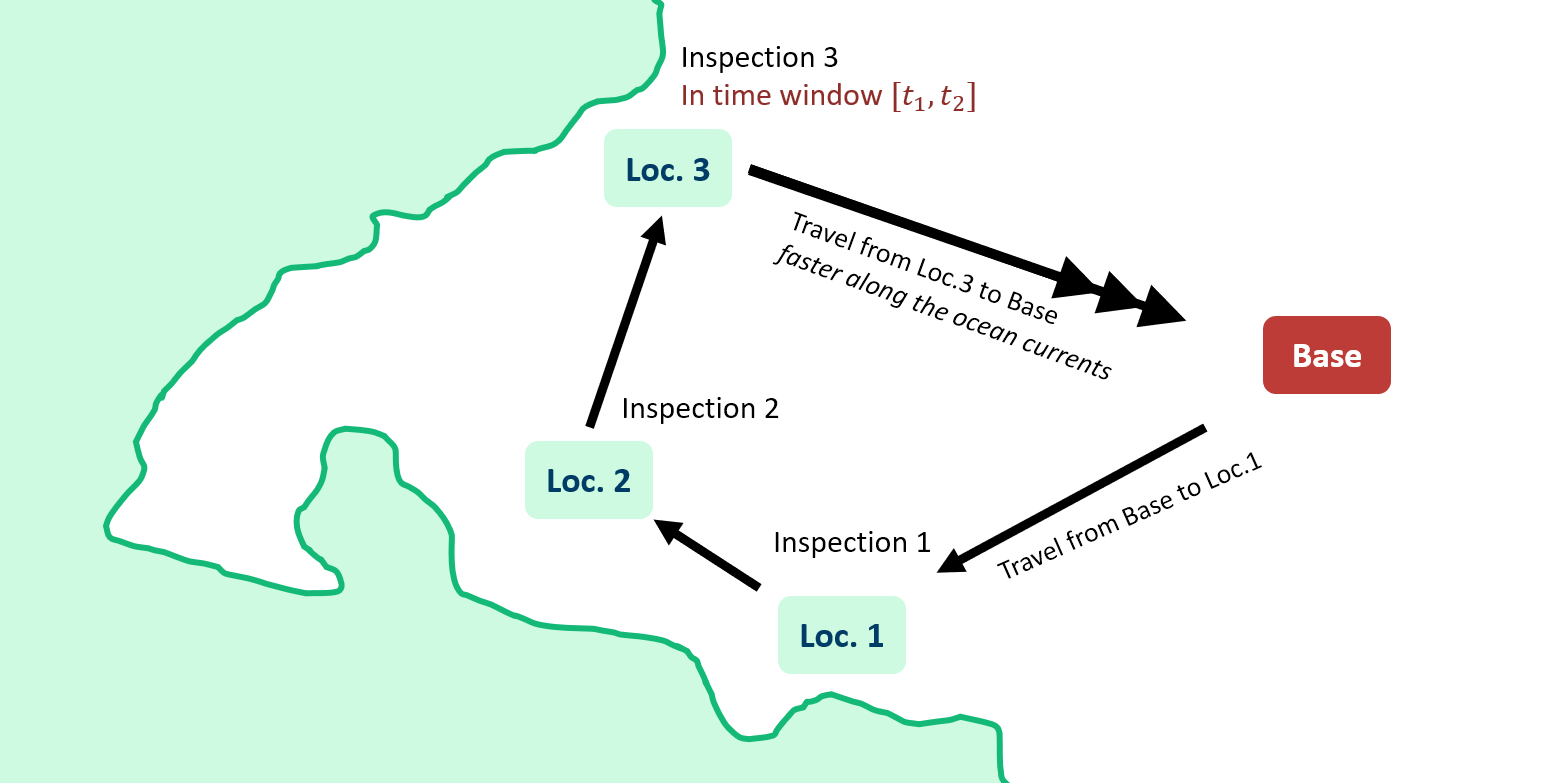

The code below implements this planning problem using the Unified Planning Framework.


## Setup

First, we need to make sure that the `unified-planning` and `up-paraspace` packages are installed.

In [44]:
!pip install unified-planning up-paraspace

## Defining the problem

Next, we'll make some data classes to represent a general form of the problem outlined above. Locations will be referred to by name (a string), and the problem definition includes a dictionary associating these location names with their 3D coordinates. Points in time are described using the `datetime` class and time durations are described using the `timedelta` class from the Python standard library. Changes in ocean current speed will be described as a list of `OceanCurrentChange`, where each entry has a point in time where the ocean current changes to a new value, resulting in a piece-wise constant function for the forecasted ocean current for the day.
We assume that the ocean currents are directed either straight eastward or straight westward. Positive numbers indicate ocean current in eastward direction, negative numbers westward. Finally, the `AUVInspectionProblem` class collects all the data, including also the description of the inspections to be performed and the relevant durations and time windows in the `Job` class.

In [45]:
from dataclasses import dataclass
from datetime import datetime, timedelta

@dataclass
class Coord:
    """3D Cartesian coordinates"""
    x: float
    y: float
    z: float


@dataclass
class AUV:
    """The robot, has a location and a movement speed"""
    start_location: str
    return_location: str | None
    speed: float


@dataclass
class Job:
    """A job has a location, a duration and a time window that it must be performed within"""
    location: str
    duration: timedelta
    earliest_start_time: datetime | None
    latest_completion_time: datetime | None


# Current changes are simplified to change instantly
@dataclass
class OceanCurrentChange:
    """An instantaneous change in the ocean current velocity"""
    time: datetime

    # The speed in m/s of the tide current. Positive numbers indicate
    # current in eastward direction, negative numbers westward.
    # The flow will be valid from the time until the next current change.
    current_speed: float


# The problem.
@dataclass
class AUVInspectionProblem:
    start_time: datetime
    locations: dict[str, Coord]
    jobs: list[Job]
    auv: AUV
    current: list[OceanCurrentChange]


## Example 1

We will set up two example problem instances. The first one is the simplest possible instance, with only one job
to be performed without time window restrictions. 


In [46]:
import datetime

def exampleproblem1():
    start_time = datetime.datetime.fromisoformat("2000-01-01")
    locations = {
        "base": Coord(0, 0, 0),
        "inspection1": Coord(0, 1, 2),
    }

    jobs = [
        Job("inspection1", timedelta(minutes=5), None, None),
    ]

    current = [
        OceanCurrentChange(start_time, 0.0),
    ]

    return AUVInspectionProblem(
        start_time=start_time,
        auv=AUV("base", "base", 1.0),
        locations=locations,
        jobs=jobs,
        current=current,
    )


exampleproblem1()

AUVInspectionProblem(start_time=datetime.datetime(2000, 1, 1, 0, 0), locations={'base': Coord(x=0, y=0, z=0), 'inspection1': Coord(x=0, y=1, z=2)}, jobs=[Job(location='inspection1', duration=datetime.timedelta(seconds=300), earliest_start_time=None, latest_completion_time=None)], auv=AUV(start_location='base', return_location='base', speed=1.0), current=[OceanCurrentChange(time=datetime.datetime(2000, 1, 1, 0, 0), current_speed=0.0)])

## Example 2

The second example is a bit more complex, with three inspections to be performed within certain time windows, and also
with current changes during the mission period.

In [47]:
def exampleproblem2():
    start_time = datetime.datetime.fromisoformat("2000-01-01")
    locations = {
        "base": Coord(0, 0, 0),
        "inspection1": Coord(15, 20, -2),
        "inspection2": Coord(-10, 10, -6),
        "inspection3": Coord(-10, 10, -1),
    }

    jobs = [
        Job("inspection1", timedelta(minutes=5.0), start_time + timedelta(minutes=30), start_time + timedelta(minutes=50)),
        Job("inspection2", timedelta(minutes=5.0), start_time + timedelta(minutes=40), start_time + timedelta(minutes=70)),
        Job("inspection3", timedelta(minutes=5.0), start_time + timedelta(minutes=50), start_time + timedelta(minutes=80)),
    ]

    current = [
        OceanCurrentChange(start_time, 0.0),
        OceanCurrentChange(start_time + timedelta(minutes=60), -1.0),
    ]

    return AUVInspectionProblem(
        start_time=start_time,
        auv=AUV("base", "base", 1.5),
        locations=locations,
        jobs=jobs,
        current=current,
    )

exampleproblem2()

AUVInspectionProblem(start_time=datetime.datetime(2000, 1, 1, 0, 0), locations={'base': Coord(x=0, y=0, z=0), 'inspection1': Coord(x=15, y=20, z=-2), 'inspection2': Coord(x=-10, y=10, z=-6), 'inspection3': Coord(x=-10, y=10, z=-1)}, jobs=[Job(location='inspection1', duration=datetime.timedelta(seconds=300), earliest_start_time=datetime.datetime(2000, 1, 1, 0, 30), latest_completion_time=datetime.datetime(2000, 1, 1, 0, 50)), Job(location='inspection2', duration=datetime.timedelta(seconds=300), earliest_start_time=datetime.datetime(2000, 1, 1, 0, 40), latest_completion_time=datetime.datetime(2000, 1, 1, 1, 10)), Job(location='inspection3', duration=datetime.timedelta(seconds=300), earliest_start_time=datetime.datetime(2000, 1, 1, 0, 50), latest_completion_time=datetime.datetime(2000, 1, 1, 1, 20))], auv=AUV(start_location='base', return_location='base', speed=1.5), current=[OceanCurrentChange(time=datetime.datetime(2000, 1, 1, 0, 0), current_speed=0.0), OceanCurrentChange(time=datetime.

## Computing the travel times
Here we make the functions for calculating the travel time between two different coordinates. For a derivation of the equation used in calculate_speed(), see the [Appendix](#Calculating-travel-times).

In [48]:
from math import sin,cos,sqrt,pow,atan2

def calculate_speed(auv_speed :float, current_speed :float, theta :float, phi :float) -> float:
    return current_speed * sin(theta) * cos(phi) + (sqrt( pow(current_speed,2) * pow(sin(theta),2) * pow(cos(phi),2) + pow(auv_speed,2) - pow(current_speed,2)))

def calculate_travel_time(a :Coord, b :Coord, auv_speed :float, current_speed :float) -> float:
    distance = sqrt(pow(b.x-a.x,2) + pow(b.y-a.y,2) + pow(b.z-a.z,2) )
    theta = atan2(b.y-a.y,b.x-a.x)
    phi = atan2(b.z-a.z, sqrt(pow(b.x-a.x, 2) + pow(b.y-a.y, 2) ))
    speed = calculate_speed(auv_speed, current_speed, theta, phi)
    return distance/speed


Here is an example of travel time computations. If the current speed is 2.0 m/s (in positive $y$ direction), 
and we are going from $x_0,y_0,z_0 = 0,0,0$ to $x_1,y_1,z_1 = 100,100,100$, and the AUV speed is 3.0 m/s, it will take $\approx 47$ seconds to travel that distance.

In [49]:
calculate_travel_time(Coord(0,0,0), Coord(100,100,100), 3, 2)

47.17797887081347

## Translating to Unified Planning Framework

Now we are ready to translate the `AUVInspectionProblem` into a `unified-planning` `Problem`.
The function `solve` takes the `AUVInspectionProblem` and returns a solution plan. Inside the function,
the conversion of the problem into the `unified-planning` problem definition is done through the following steps:

 * Adding finite domain types (`UserType`) for representing locations, jobs, job status (ready/processing/done), 
current speed periods, time window status (inside/outside the time window).
 * Adding **static fluents** describing the state changes that we have no control over, i.e. the time windows and the
ocean current changes. Time and duration values are rounded to integer minutes.
 * Adding location actions describing the transition between each pair of locations. This is where the `calculate_travel_time` function is used. We are assuming that the current doesn't change while the AUV is moving. This might become a problem if the current changes many times.
 * Adding inspection actions describing the conditions for performing the `Job`s.
 * Finally, adding goals saying that all `Job`s should be `Done` and the AUV should be at the `return_location` at the end of the planning horizon.

For several of the features of this planning problem, there are multiple ways to translate our problem definition into `unified-planning`. For this demo, we have used a style of translation that is suited for translation into the timelines-based formalism underlying the Paraspace planner. For example, the (static) time windows are not directly enforced by `add_condition` on the relevant actions, but are instead described as static fluents, and the actions have conditions that they have to happen during the *Inside* value on the *time window fluent*. Similarly, transitional location objects (e.g., being on the path between *base* and *location1*) are added so that there is a specific temporary value for the location fluent to take while the travel is happening. See the [Appendix](#Appendix) below for details on the limitation imposed by Paraspace.

In [50]:
import datetime
import math
import typing
import unified_planning
import time
import up_paraspace
from unified_planning.shortcuts import *

def convert_timedelta(t :timedelta) -> int:
    """Convert a `timedelta` to a whole number of minutes."""
    return int(round(t.seconds / 60.0))

def solve(orig_problem: AUVInspectionProblem):
    #
    # We convert the AUVInspectionProblem into a unified-planning problem.
    #
    upf_problem = unified_planning.model.Problem("AUV_Inspection_Problem")

    #
    # Locations are modelled as a fluent with an object for every possible location.
    #
    Location = UserType("Location")
    locations = {l: upf_problem.add_object(l, Location) for l in orig_problem.locations.keys()}

    auv_location = upf_problem.add_fluent(
        "auv_location", Location, default_initial_value=locations[orig_problem.auv.start_location]
    )

    #
    # Job statuses are objects
    #
    JobStatusType = UserType("JobStatus")
    JobStatusReady = upf_problem.add_object(f"Ready", JobStatusType)
    JobStatusProcessing = upf_problem.add_object(f"Processing", JobStatusType)
    JobStatusDone = upf_problem.add_object(f"Done", JobStatusType)

    #
    # Jobs are objects
    #
    Job = UserType("Job")
    job_objs = [upf_problem.add_object(f"job{i}", Job) for i, _ in enumerate(orig_problem.jobs)]

    job_status = upf_problem.add_fluent(
        "job_status",
        JobStatusType,
        job=Job,
        default_initial_value=JobStatusReady,
    )

    #
    # Current speed periods: one object per period and one fluent to represent the current current period.
    #
    CurrentSpeed = UserType("CurrentSpeed")
    current_speeds = [upf_problem.add_object(f"cur{i}", CurrentSpeed) for i, _ in enumerate(orig_problem.current)]
    current_speed = upf_problem.add_fluent("current_speed", CurrentSpeed, default_initial_value=current_speeds[0])

    for i, c in enumerate(orig_problem.current):
        if i >= 1:
            timing = GlobalStartTiming(convert_timedelta(c.time - orig_problem.start_time))
            upf_problem.add_timed_effect(timing, current_speed, current_speeds[i])

    #
    # Time windows
    #
    TimeWindowStatus = UserType("TimeWindowStatus")
    TimeWindowStatusOutside = upf_problem.add_object(f"TimeWindowStatusOutside", TimeWindowStatus)
    TimeWindowStatusInside = upf_problem.add_object(f"TimeWindowStatusInside", TimeWindowStatus)

    job_timewindows = []
    for job_idx, job in enumerate(orig_problem.jobs):
        if job.earliest_start_time is None and job.latest_completion_time is None:
            job_timewindows.append(None)
            continue

        initial_value = TimeWindowStatusOutside if job.earliest_start_time is not None else TimeWindowStatusInside
        tw = upf_problem.add_fluent(f"tw_j{job_idx}", TimeWindowStatus, default_initial_value=initial_value)

        if job.earliest_start_time is not None:
            timing = GlobalStartTiming(convert_timedelta(job.earliest_start_time - orig_problem.start_time))
            upf_problem.add_timed_effect(timing, tw, TimeWindowStatusInside)

        if job.latest_completion_time is not None:
            timing = GlobalStartTiming(convert_timedelta(job.latest_completion_time - orig_problem.start_time))
            upf_problem.add_timed_effect(timing, tw, TimeWindowStatusOutside)

        job_timewindows.append(tw)

    #
    # Travel actions
    #

    for loc1 in orig_problem.locations.keys():
        for loc2 in orig_problem.locations.keys():
            if loc1 == loc2:
                continue

            for current_idx, current in enumerate(orig_problem.current):
                move_action = DurativeAction(f"move_{loc1}_{loc2}_cur{current_idx}")

                coords1 = orig_problem.locations[loc1]
                coords2 = orig_problem.locations[loc2]
                duration = int(
                    round(calculate_travel_time(coords1, coords2, orig_problem.auv.speed, current.current_speed))
                )

                transit_location = upf_problem.add_object(f"transit_{loc1}_{loc2}_cur{current_idx}", Location)

                move_action.set_fixed_duration(duration)
                move_action.add_condition(StartTiming(), Equals(auv_location, locations[loc1]))
                move_action.add_effect(StartTiming(), auv_location, transit_location)
                move_action.add_effect(EndTiming(), auv_location, locations[loc2])
                move_action.add_condition(
                    ClosedTimeInterval(StartTiming(), EndTiming()), Equals(current_speed, current_speeds[current_idx])
                )

                upf_problem.add_action(move_action)

    #
    # Job actions
    #
    for i, (job, job_obj) in enumerate(zip(orig_problem.jobs, job_objs)):
        job_action = DurativeAction(f"process_job{i}")
        this_job_status = job_status(job_obj)

        job_action.set_fixed_duration(convert_timedelta(job.duration))
        job_action.add_condition(StartTiming(), Equals(this_job_status, JobStatusReady))
        job_action.add_effect(StartTiming(), this_job_status, JobStatusProcessing)
        job_action.add_effect(EndTiming(), this_job_status, JobStatusDone)

        job_action.add_condition(
            ClosedTimeInterval(StartTiming(), EndTiming()), Equals(auv_location, locations[job.location])
        )

        if job_timewindows[i] is not None:
            job_action.add_condition(
                ClosedTimeInterval(StartTiming(), EndTiming()), Equals(job_timewindows[i], TimeWindowStatusInside)
            )

        upf_problem.add_action(job_action)

        # Goal: peform job
        upf_problem.add_goal(Equals(this_job_status, JobStatusDone))

    # Goal: return to specified location
    if orig_problem.auv.return_location is not None:
        upf_problem.add_goal(Equals(auv_location, locations[orig_problem.auv.return_location]))

    t0 = time.time()
    with OneshotPlanner(name="paraspace", problem_kind=upf_problem.kind) as planner:
        result = planner.solve(upf_problem)
        print("%s returned: %s" % (planner.name, result.plan))

    t1 = time.time()
    print(f"Solved AUV problem in {t1-t0:.2f} seconds")
    return result


## Solving example 1

In [51]:
solve(exampleproblem1())

paraspace returned: TimeTriggeredPlan:
    1.0: move_base_inspection1_cur0 [2.0]
    3.0: process_job0 [5.0]
    8.0: move_inspection1_base_cur0 [2.0]
Solved AUV problem in 0.02 seconds


PlanGenerationResult(status=<PlanGenerationResultStatus.SOLVED_SATISFICING: 1>, plan=TimeTriggeredPlan([(1.0, move_base_inspection1_cur0, 2.0), (8.0, move_inspection1_base_cur0, 2.0), (3.0, process_job0, 5.0)]), engine_name='paraspace', metrics=None, log_messages=None)

## Solving example 2

In [52]:
solve(exampleproblem2())

paraspace returned: TimeTriggeredPlan:
    1.0: move_base_inspection2_cur0 [10.0]
    12.0: move_inspection2_inspection1_cur0 [18.0]
    30.0: process_job0 [5.0]
    35.0: move_inspection1_inspection2_cur0 [18.0]
    53.0: process_job1 [5.0]
    64.0: move_inspection2_inspection3_cur1 [4.0]
    68.0: process_job2 [5.0]
    73.0: move_inspection3_base_cur1 [7.0]
Solved AUV problem in 0.04 seconds


PlanGenerationResult(status=<PlanGenerationResultStatus.SOLVED_SATISFICING: 1>, plan=TimeTriggeredPlan([(1.0, move_base_inspection2_cur0, 10.0), (12.0, move_inspection2_inspection1_cur0, 18.0), (35.0, move_inspection1_inspection2_cur0, 18.0), (64.0, move_inspection2_inspection3_cur1, 4.0), (73.0, move_inspection3_base_cur1, 7.0), (30.0, process_job0, 5.0), (53.0, process_job1, 5.0), (68.0, process_job2, 5.0)]), engine_name='paraspace', metrics=None, log_messages=None)

# Appendix

## Paraspace timeline conversion limitations

The planning problem definition used by paraspace is more restricted than the planning problem
definition used by the Unified Planning Framework (and PDDL and ANML).
`up-paraspace` has two different modes for translating UPF planning problems into
the Paraspace timelines problem definition: 
**classical** conversion and **timelines** conversion. 
The classical conversion supports finite domain fluents and instantaneous actions, but
is not a particularly efficient planner for those types of problems.

The timelines conversion produces a problem description that is more efficiently solvable using Paraspace's algorithm, 
and also supports durative actions, but imposes some restrictions on how the UPF problem is formed. 
If the `up-paraspace` module can detect that the UPF problem follows a certain pattern, the
**timelines** conversion can be used. The pattern is roughly the following:

 * All (grounded) fluents are either finite domain types (Boolean or UserType), or integers with a 
    lower bound of zero and no upper bound. Integer fluents are used below as *resources*.
 * All actions are durative actions with fixed (constant) durations, 
    and describe an allowed transition from a previous value and a transition to a next value of the same finite-domain fluent.
   Conditions and effects must follow the following pattern:
      * There is an equality condition at the start of the action, between a fluent (corresponding to the action's transition fluent) and a constant.
    *  At the start of the action, there is an effect setting the same fluent (corresponding to the action's transition fluent) to a value.
    *  At the end of the action, there is an effect setting the same fluent (corresponding to the action's transition fluent) to a value.
   
   All of the above conditions/effects must be found in each action. Other conditions may also be applied, but they need to relate start and end  times of a timeline with conditions.  No other effects can be present in the action, except for *increase* and *decrease* effects with the following pattern:
    
    * At start, an effect may increase a resource by a constant integer amount. If so,         it must also, at end, decrease the same resource by the same amount.         This pattern represents that the action provides a resource.
    * At start, an effect may decrease a resource by a constant integer amount.        If so, it must also, at end, increase the same resource by the same amount.        This pattern represents that the action temporarily consumes a (renewable) resource.
   
For the AUV inspection problem, the timelines conversion will produce a Paraspace problem containing the objects in the diagram below. Each timeline/component has a transition graph describing the allowed sequences of values for that (finite domain) fluent, and 
the dashed red lines indicate a synchronization condition, forcing the timing of different values to adhere to temporal constraints.



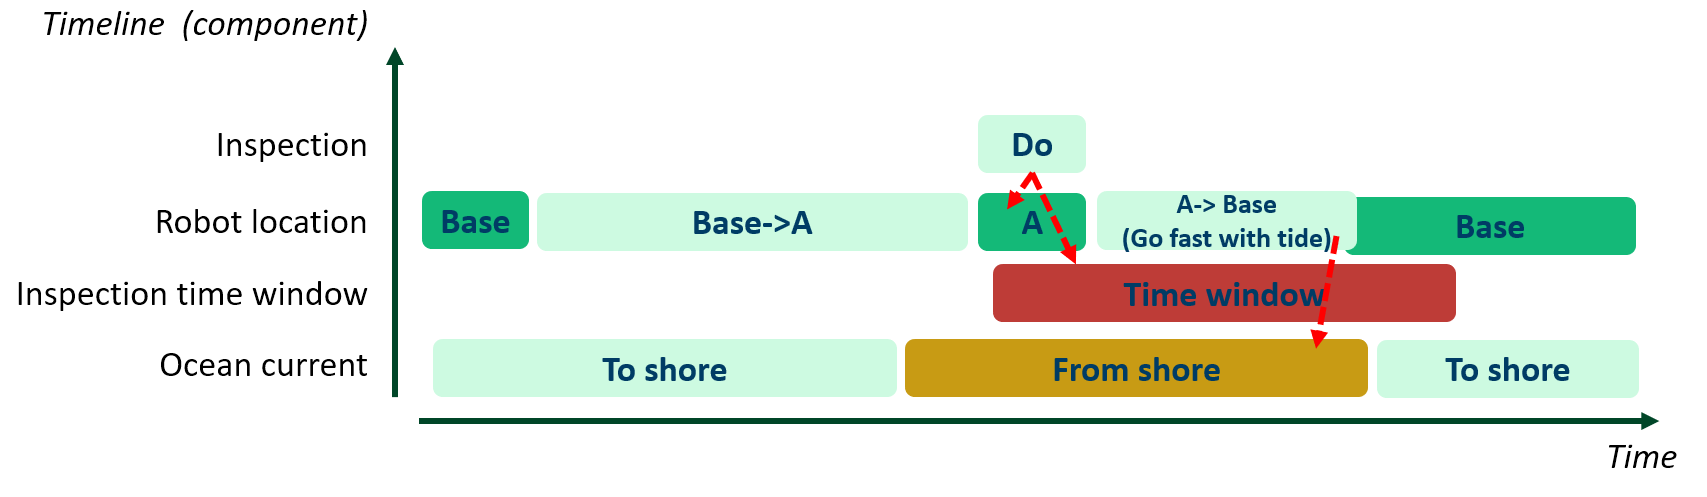


## Calculating travel times
Given two points $P_{0} = (x_{0}, y_{0}, z_{0})$ and $P_{1} = (x_{1}, y_{1}, z_{1})$, we want to calculate the shortest time it takes to get there, given a boat with speed $v_{boat}$ and a contribution from the tide $v_{tide}$. We assume $v_{tide}$ is constant and only contributes in the $y$ direction. We denote the angle from $P_{1}$ to $P_{0}$ in the XY plane with respect to the x-axis as $\theta$, and the angle between the XY-plane and the z-axis as $\phi$ (see figure). To adjust for the tide, the boat has to aim in a certain direction $\theta'$ to compensate for the tide. The resulting velocity vector $\vec{v}$ should point directly toward $P_{1}$ with speed $v$, giving us a boost if we travel with the tide or slow us down if we travel against the tide. Some simple trigonometry gives:

$v_{x} = v\cos{\theta}\cos{\phi} = v_{boat}\cos{\theta'}\cos{\phi}$

$v_{y} = v\sin{\theta}\cos{\phi} = v_{boat,y} + v_{tide} = v_{boat}\sin{\theta'}\cos{\phi} + v_{tide}$,

$v_{z} = v\sin{\phi} = v_{boat}\sin{\phi}$

and

$v^{2} = v_{x}^{2} + v_{y}^{2} + v_{z}^{2} = v_{boat}^{2}\cos^{2}{\theta'}\cos^{2}{\phi} + (v_{boat}\sin{\theta'}\cos{\phi} + v_{tide})^{2} + v_{boat}^{2}\sin^{2}{\phi}$.

Rearranging the last equation a bit we get

$\sin{\theta'} = \frac{v^{2} - v_{boat}^{2} - v_{tide}^{2}}{2v_{boat}v_{tide}\cos{\phi}}$

Inserting above gives

$v\sin{\theta}\cos{\phi} = v_{boat}\cos{\phi}\frac{v^{2} - v_{boat}^{2} - v_{tide}^{2}}{2v_{boat}v_{tide}\cos{\phi}} + v_{tide}$.

Solving for $v$ we end up with the following expression for $v(\theta,\phi)$:

$v(\theta,\phi) = v_{tide}(\sin{\theta}\cos{\phi} \pm \sqrt{\sin^{2}{\theta}\cos^{2}{\phi} + (\frac{v_{boat}}{v_{tide}})^{2} - 1} )$.

Where the two different solutions represent two different outset directions that will reach the goal. (If e.g. $v_{tide} > v_{boat}$ and we want to travel directly along y (i.e. $\theta = \frac{\pi}{2}$ and $\phi = 0$ which gives $v = v_{tide} \pm v_{boat}$), traveling both with and against the current will get you there) We always want the maximal speed, so we choose the solution where we add the square root contribution. 

## From above

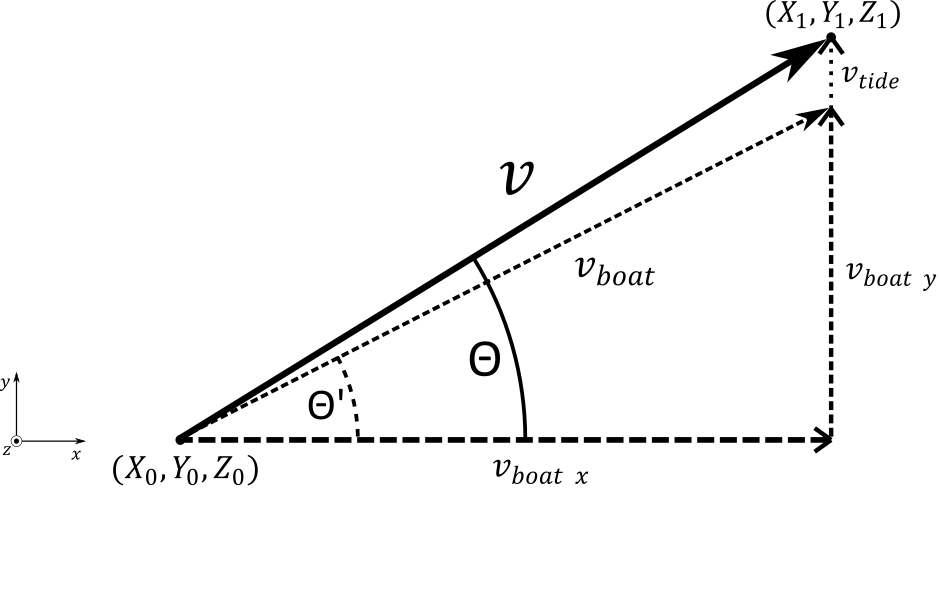


## From the side

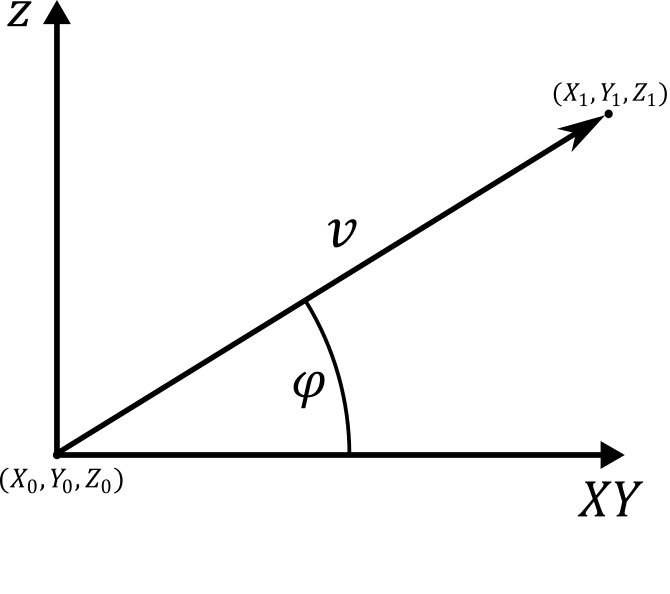


